In [1]:
%matplotlib inline

##### MNIST template

## Tarea 5

Escuela de Ingeniería Electrónica<br>
EL5857 Aprendizaje Automático<br>
I Semestre 2023

Este archivo permite cargar el set de datos MNIST para ser usado con scikit-learn.

Puede usarlo como base para entrenar sus modelos, y para la selección de modelos.  Debe guardar sus modelos en un archivo para utilizar los mejores de ellos en ``predict_digit.ipynb``, sin necesidad de entrenar todo de nuevo cuando solo se quiera predecir.

MNIST es un set de datos bastante utilizado, y existen múltiples posibilidades de cargarlo en programas de Python.

- Usando ``fetch_openml`` de ``sckit-learn`` es una opción pero tiene en algunas versiones el problema de que baja todo el conjunto de internet cada vez que se ejecuta el programa, lo que no lo hace viable.
- Usando el paquete ``python-mnist``, que no existe en las distribuciones de conda.
- Usando el paquete ``mnist``.
- Usando ``pandas``.

Aquí usaremos la versión que usa el paquete ``mnist``, para evitar dependencias adicionales a bibliotecas grandes.

Dicho paquete carga los datos como un tensor de 60000x28x28, es decir, 60000 imágenes de 28x28 dimensiones.  Cada pixel es de tipo entero sin signo de 8 bits.

In [2]:
# Si le falta la biblioteca 'mnist' y usa Anaconda:
#!conda install mnist

# o cualquier otra distribución de Python:
#!pip install mnist

In [3]:
import mnist
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import OneHotEncoder

try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except:
    print("No scikit-learn-intelex found.  We go on with the classic implementation.")

import time
from pathlib import Path

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
tic=time.time()

# Asegure que el directorio de datos existe.
datadir='./mnist_data/'
Path(datadir).mkdir(parents=False, exist_ok=True)

# temporary_dir es una función que retorna el directorio temporal;
mnist.temporary_dir = lambda: datadir

# Prepare el codificador 'one-hot'
enc = OneHotEncoder(handle_unknown='ignore')

# La primera vez, esto puede tardar unos segundos a minutos por tener
# que bajar los datos originales de internet.
# Después de eso debería ser rápido.

# Prepare los datos de entrenamiento
train_images = mnist.train_images() # Esto es un tensor m x 28 x 28
train_labels = mnist.train_labels().astype(int)
train_ohelab = enc.fit_transform(train_labels.reshape(-1,1)).toarray() # labels one-hot encoded

m,h,w=train_images.shape
train_data = train_images.reshape((m,w*h)).astype(float)/255 # Esto es una matrix de m x 784

# Prepare los datos de validación
val_images = mnist.test_images() # Esto es un tensor de m x 28 x 28
val_labels = mnist.test_labels().astype(int)
val_ohelab = enc.transform(val_labels.reshape(-1,1)).toarray()

vm,vh,vw=val_images.shape
val_data = val_images.reshape((vm,vw*vh)).astype(float)/255 # Esto es una matrix de m x 784


toc=time.time()-tic
print("Tardó: {0} s".format(toc))

print("Entrenamiento: {0} datos de {1}x{2} dimensiones".format(m,h,w))
print("Validación   : {0} datos de {1}x{2} dimensiones".format(vm,vh,vw))

Tardó: 0.7489967346191406 s
Entrenamiento: 60000 datos de 28x28 dimensiones
Validación   : 10000 datos de 28x28 dimensiones


A este punto, se cuenta con la siguiente información para poder entrenar:

- train_data: arreglo de 60000 datos de 784 dimensiones
- train_label: vector de 60000 etiquetas como enteros entre 0 y 9
- train_ohelab: arreglo de 60000x10 con la codificación de las etiquetas _one-hot_
- val_data: arreglo de 10000 datos de 784 dimensiones
- val_label: vector de 10000 etiquetas como enteros entre 0 y 9
- val_ohelab: arreglo de 10000x10 con la codificación de las etiquetas _one-hot_


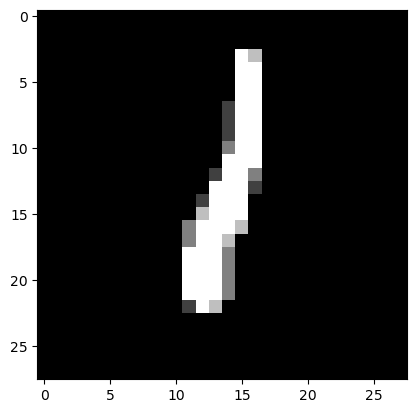

Etiqueta entera: 1
         one-hot: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


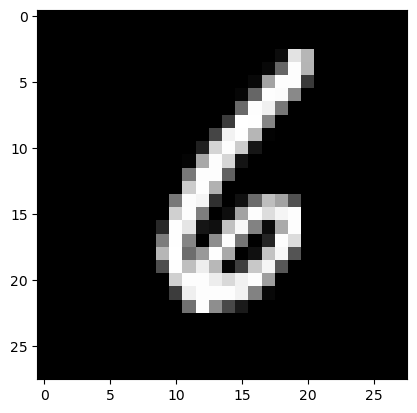

Etiqueta entera: 6
         one-hot: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


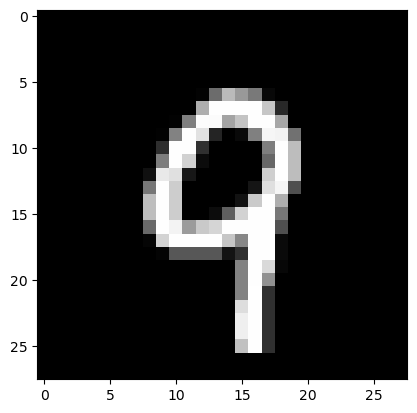

Etiqueta entera: 9
         one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


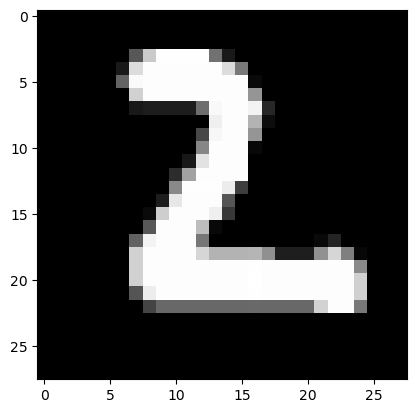

Etiqueta entera: 2
         one-hot: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
# Muestre algunas muestras
samples = np.random.choice(np.arange(m),4,replace=False)

for i in samples:
    plt.imshow(train_data[i].reshape((28,28)),cmap='gray')
    plt.show()

    print("Etiqueta entera:",train_labels[i])
    print("         one-hot:",train_ohelab[i])


## Entrenar/seleccionar modelos

A continuación usted debe entrenar y seleccionar los modelos, y guardar el mejor de ellos para cada tipo (SVM, RDF, kNN)

No olvidar la regla de oro: **¡siempre se deben normalizar los datos!**

Tardó: 26.114457607269287 s


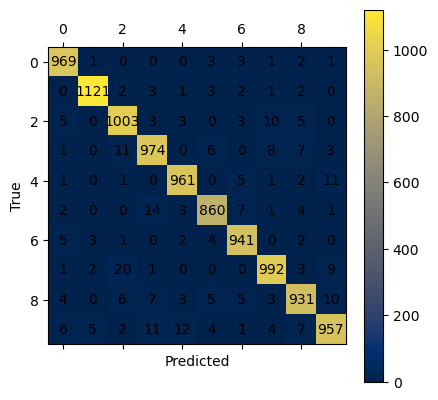

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
tic=time.time()
## Proceso de normalización Min-Max ***************************

## Al asignar un valor de 1, el proceso de normalización es estándar.
## Al asignar un valor de 2, el proceso de normalización es MinMax.

metodonormalizar = 2

# *************************************************************
if metodonormalizar == 1:

  from sklearn.preprocessing import StandardScaler

  # Normalizar los datos de entrenamiento
  scaler = StandardScaler()
  train_data_norm = scaler.fit_transform(train_data)

  # Normalizar los datos de validación
  val_data_norm = scaler.transform(val_data)

elif metodonormalizar == 2:

  from sklearn.preprocessing import MinMaxScaler

  # Normalizar los datos de entrenamiento
  scaler = MinMaxScaler()
  train_data_norm = scaler.fit_transform(train_data)

  # Normalizar los datos de validación
  val_data_norm = scaler.transform(val_data)

# Crear un clasificador RDF con 100 árboles
clf = RandomForestClassifier(n_estimators=100)

# Entrenar el modelo con los datos de entrenamiento normalizados
clf.fit(train_data_norm, train_labels)

# Predecir las etiquetas para los datos de validación normalizados
predicted_labels = clf.predict(val_data_norm)

toc=time.time()-tic
print("Tardó: {0} s".format(toc))

pickle.dump(clf, open('Modelos/Modelo_RDF.sav', 'wb'))


with open('Normalizadores/scaler_RDF.pkl', 'wb') as f:
    pickle.dump(scaler, f)





# Calcular la matriz de confusión
cm = confusion_matrix(val_labels, predicted_labels)

# Visualizar la matriz de confusión

plt.matshow(cm,cmap='cividis')
# Calcular la matriz de confusión
cm = confusion_matrix(val_labels, predicted_labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import ParameterGrid

#clasificador_svm = pickle.load(open('Modelos/Modelo_SVM.sav', 'rb'))
train_labels2 = np.argmax(train_ohelab, axis=1)
tic=time.time()

def Mejores_Parametros(model, X, y, params_grid, cv=5):
    """
    Función para buscar los mejores hiperparámetros para un modelo utilizando validación cruzada y el frente de Pareto.
    
    :param model: Modelo a utilizar
    :param X: Datos de entrenamiento
    :param y: Etiquetas de entrenamiento
    :param params_grid: Diccionario con los hiperparámetros a evaluar y sus posibles valores
    :param cv: Número de particiones para la validación cruzada
    :return: Lista con los mejores hiperparámetros encontrados en el frente de Pareto
    """
    # Crear objeto KFold
    kf = KFold(n_splits=cv)
    
    # Crear objeto ParameterGrid
    param_grid = ParameterGrid(params_grid)
    
    # Lista para almacenar los resultados
    precGen = []
    recGen = []
    entrenamiento = 0
    seccion = 0
    
    # Iterar sobre todas las combinaciones de hiperparámetros
    for params in param_grid:
        # Establecer los hiperparámetros del modelo
        model.set_params(**params)
        
        # Listas para almacenar las métricas de cada partición
        precisions = []
        recalls = []
        resultsPrecSVM = []
        resultsRecSVM = []
        
        # Iterar sobre las particiones de validación cruzada
        for train_index, test_index in kf.split(X):
            # Obtener los datos de entrenamiento y validación para esta partición
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Entrenar el modelo
            model.fit(X_train, y_train)
            
            # Predecir las etiquetas para los datos de validación
            y_pred = model.predict(X_test)
            
            # Calcular la precisión y la exhaustividad para esta partición
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            
            # Agregar las métricas a las listas correspondientes
            precisions.append(precision)
            recalls.append(recall)
        
            # Calcular el promedio de las métricas para todas las particiones
            mean_precision = np.mean(precisions)
            mean_recall = np.mean(recalls)

            resultsPrecSVM.append(mean_precision)
            resultsRecSVM.append(mean_recall)

            seccion += 1
            print("Entrenamiento numero", entrenamiento, "seccion", seccion)
            print(resultsPrecSVM)
            print(resultsRecSVM)
        
        precGen.append(resultsPrecSVM)
        recGen.append(resultsRecSVM)
        seccion = 0
        entrenamiento += 1
    return precGen, recGen 
cv=5
params_grid = [{'criterion': ['gini'], 'n_estimators': [50,200,500]},{'criterion': ['entropy'], 'n_estimators': [50,200,500]}]
# Supongamos que tenemos nuestros datos de entrenamiento en las variables X_train e y_train
X_train=train_data_norm
y_train=train_labels2

# Llamar a la función search_best_params para buscar los mejores hiperparámetros
#best_params = search_best_params(clasificador_svm, X_train, y_train, params_grid)
Resultados = Mejores_Parametros(clf, X_train, y_train, params_grid,cv)
resultsPrecSVM = Resultados[0]
resultsRecSVM = Resultados[1]
toc=time.time()-tic
print("Tardó: {0} s".format(toc))

Entrenamiento numero 0 seccion 1
[0.9663192760263002]
[0.9663992472767984]
Entrenamiento numero 0 seccion 2
[0.9663192760263002, 0.9639773688934083]
[0.9663992472767984, 0.9639981060689298]
Entrenamiento numero 0 seccion 3
[0.9663192760263002, 0.9639773688934083, 0.9636600114023105]
[0.9663992472767984, 0.9639981060689298, 0.9636551265111383]
Entrenamiento numero 0 seccion 4
[0.9663192760263002, 0.9639773688934083, 0.9636600114023105, 0.9633003393349387]
[0.9663992472767984, 0.9639981060689298, 0.9636551265111383, 0.9633097310862319]
Entrenamiento numero 0 seccion 5
[0.9663192760263002, 0.9639773688934083, 0.9636600114023105, 0.9633003393349387, 0.964484713161791]
[0.9663992472767984, 0.9639981060689298, 0.9636551265111383, 0.9633097310862319, 0.9644946480466956]
Entrenamiento numero 1 seccion 1
[0.9700863705765336]
[0.9701248200067821]
Entrenamiento numero 1 seccion 2
[0.9700863705765336, 0.9689776258730958]
[0.9701248200067821, 0.9689529103418699]
Entrenamiento numero 1 seccion 3
[0.

[False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False]


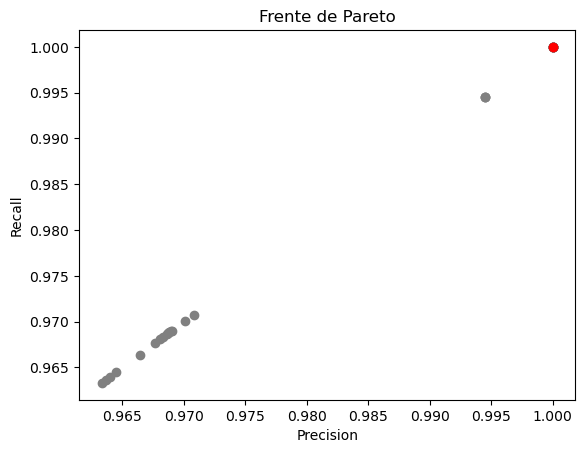

In [8]:
from proceso_pareto import proceso_pareto

v_eficientes=proceso_pareto(resultsPrecSVM, resultsRecSVM)

In [9]:
parusado=[]

param_grid = ParameterGrid(params_grid)
i=0
for params in param_grid:
    parusado.append(params)
    j=0
    for j in range(cv):
        if(v_eficientes[i]):
            par_correcto=params
        i=i+1

print('El parametro optimo es')
print(par_correcto)
#Entrena con el parametro optimo
clf.set_params(**par_correcto)
train_labels2 = np.argmax(train_ohelab, axis=1)
clf.fit(train_data_norm, train_labels2)
pickle.dump(clf, open('Modelos/Modelo_RDF_op.sav', 'wb'))

El parametro optimo es
{'criterion': 'entropy', 'n_estimators': 50}


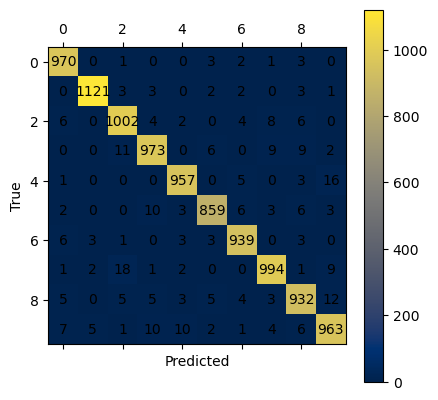

In [10]:
# Calcular la matriz de confusión para parametros optimos
predicted_labels = clf.predict(val_data_norm)
cm = confusion_matrix(val_labels, predicted_labels)

# Visualizar la matriz de confusión

plt.matshow(cm,cmap='cividis')
# Calcular la matriz de confusión
cm = confusion_matrix(val_labels, predicted_labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()